In [1]:
import os
import torch
from torch.nn import functional as F
import random

import commons
import utils

from models_bigvgan import SynthesizerTrn

from mel_processing import mel_spectrogram_torch, spec_to_mel_torch, spectrogram_torch
from utils import load_wav_to_torch
import soundfile as sf

import IPython.display
import numpy as np
import json
from torchaudio import transforms

def Audio(audio: np.ndarray, sr: int):
    """
    Use instead of IPython.display.Audio as a workaround for VS Code.
    `audio` is an array with shape (channels, samples) or just (samples,) for mono.
    """

    if np.ndim(audio) == 1:
        channels = [audio.tolist()]
    else:
        channels = audio.tolist()

    return IPython.display.HTML("""
        <script>
            if (!window.audioContext) {
                window.audioContext = new AudioContext();
                window.playAudio = function(audioChannels, sr) {
                    const buffer = audioContext.createBuffer(audioChannels.length, audioChannels[0].length, sr);
                    for (let [channel, data] of audioChannels.entries()) {
                        buffer.copyToChannel(Float32Array.from(data), channel);
                    }
            
                    const source = audioContext.createBufferSource();
                    source.buffer = buffer;
                    source.connect(audioContext.destination);
                    source.start();
                }
            }
        </script>
        <button onclick="playAudio(%s, %s)">Play</button>
    """ % (json.dumps(channels), sr))
    
upsample = transforms.Resample(
    orig_freq=22050,
    new_freq=44100,
    resampling_method="kaiser_window",
    lowpass_filter_width=6,
    rolloff=0.99,
    dtype=torch.float32,
)

# convert audio to mel spectrogram
def audio_to_mel_spectrogram(audio):
    y_hat_mel = mel_spectrogram_torch(
        audio.float().squeeze(1),
        hps.data.filter_length,
        hps.data.n_mel_channels,
        hps.data.sampling_rate,
        hps.data.hop_length,
        hps.data.win_length,
        hps.data.mel_fmin,
        hps.data.mel_fmax,
    )
    return y_hat_mel

def audio_to_spectrogram(audio):
    spec = spectrogram_torch(
        audio,
        hps.data.filter_length,
        hps.data.sampling_rate,
        hps.data.hop_length,
        hps.data.win_length,
        center=False,
    )
    return spec



def plot_spectrogram_to_numpy(spectrogram):
    import matplotlib.pylab as plt
    import numpy as np
  
    fig, ax = plt.subplots(figsize=(10,2))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                    interpolation='none')
    plt.colorbar(im, ax=ax)
    plt.xlabel("Frames")
    plt.ylabel("Channels")
    plt.tight_layout()

    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()
    return fig

In [2]:
hps = utils.get_hparams_from_dir("/home/alex/projects/BigVGAN/models")
hps

{'train': {'log_interval': 200, 'eval_interval': 5000, 'seed': 1234, 'epochs': 20000, 'learning_rate': 0.0001, 'betas': [0.8, 0.99], 'eps': 1e-09, 'batch_size': 12, 'fp16_run': True, 'lr_decay': 0.999875, 'segment_size': 16384, 'init_lr_ratio': 1, 'warmup_epochs': 0, 'c_mel': 45}, 'data': {'training_files': './dataset/VCTK-Corpus/preprocessed_npz', 'validation_files': './dataset/VCTK-Corpus/preprocessed_npz', 'text_cleaners': ['english_cleaners2'], 'max_wav_value': 32768.0, 'sampling_rate': 44100, 'filter_length': 2048, 'hop_length': 512, 'win_length': 1024, 'n_mel_channels': 80, 'mel_fmin': 0.0, 'mel_fmax': None, 'add_blank': True, 'n_speakers': 108, 'cleaned_text': True, 'aug_rate': 1.0, 'top_db': 20}, 'model': {'p_dropout': 0.1, 'resblock_kernel_sizes': [3, 7, 11], 'resblock_dilation_sizes': [[1, 3, 5], [1, 3, 5], [1, 3, 5]], 'upsample_rates': [8, 8, 2, 2, 2], 'upsample_initial_channel': 512, 'upsample_kernel_sizes': [16, 16, 4, 4, 4], 'use_spectral_norm': False}, 'model_dir': '/hom

In [3]:
net_g = SynthesizerTrn(
    hps.data.filter_length // 2 + 1,
    hps.train.segment_size // hps.data.hop_length,
    rank="cpu",
    **hps.model
)

utils.load_checkpoint(utils.latest_checkpoint_path(hps.model_dir, "G_*.pth"), net_g, None)

net_g.eval()

/home/alex/projects/BigVGAN/models/G_35000.pth
INFO:root:Loaded checkpoint '/home/alex/projects/BigVGAN/models/G_35000.pth' (iteration 4)


SynthesizerTrn(
  (dec): Generator(
    (conv_pre): Conv1d(1025, 512, kernel_size=(7,), stride=(1,), padding=(3,))
    (ups): ModuleList(
      (0): ConvTranspose1d(512, 256, kernel_size=(16,), stride=(8,), padding=(4,))
      (1): ConvTranspose1d(256, 128, kernel_size=(16,), stride=(8,), padding=(4,))
      (2): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,))
      (3): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,), padding=(1,))
      (4): ConvTranspose1d(32, 16, kernel_size=(4,), stride=(2,), padding=(1,))
    )
    (resblocks): ModuleList(
      (0): AMPBlock(
        (upsampling_with_lfilter): Resample()
        (downsampling_with_lfilter): Resample()
        (convs1): ModuleList(
          (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
          (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(5,), dilation=(5,))
        )
    

In [4]:
filename = "/mnt/d/DIA_MARVIN_QM301_CLEANUP_15_01.wav"
audio, sampling_rate = load_wav_to_torch(filename)

audio_norm = audio / hps.data.max_wav_value
audio_norm = audio_norm.unsqueeze(0)

audio_upsampled = upsample(audio_norm)

spec = spectrogram_torch(
    audio_upsampled,
    hps.data.filter_length,
    hps.data.sampling_rate,
    hps.data.hop_length,
    hps.data.win_length,
    center=False,
)

with torch.no_grad():
    y_hat = net_g.infer(spec)

    audio_out = y_hat.squeeze()
    
sf.write('/mnt/d/upsampled.wav', audio_upsampled.squeeze(0), 44100)
sf.write('/mnt/d/Upped.wav', audio_out, 44100)
Audio(audio_out, 44100)


/home/alex/projects/work_dir/audio-augment/.venv/lib/python3.8/site-packages/torch/functional.py:572: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:659.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f62f81f9790>


/tmp/ipykernel_24003/769396767.py:100: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')


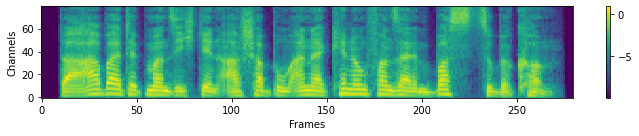

In [6]:
plot_spectrogram_to_numpy(audio_to_mel_spectrogram(audio_upsampled).squeeze(0))

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f62f80cd820>


/tmp/ipykernel_24003/769396767.py:100: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')


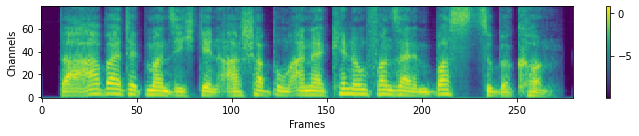

In [8]:
plot_spectrogram_to_numpy(audio_to_mel_spectrogram(y_hat.squeeze(0)).squeeze(0))